# Interest Rate Spreads
Interest rate spreads are sometimes used as a harbinger of upcoming economic slowdowns. The most widely used ones are the difference between: 1) 10-year and 2-year Treasury yields, and 2) 10-year and 3-month Treasury yields. In an economy that is expected to grow at a steady pace over 10 years, the difference is likely to be positive. In case of an impending recession the difference can turn negative.

Looking at just this treasury yield spread alone doesn't assuredly tell us if the inversion can be mostly attributed to an upcoming recession or to differences in inflation expectations. Lower long-term inflation expectations compared to short-term ones can also lead to an inversion in the treasury yield curve. This is because a treasury yield is made up of:

`Treasury yield = expected average future real short rate + real term premium + expected inflation + inflation risk premium (1)`

where the `inflation risk premium` and the `real term premium` are extra compensations bond investors demand for bearing inflation risks and real interest rate risks, respectively. I.e. the risks that actual inflation and short term rates will turn out to be different from those expected. Expected average future real short rate is related to expected real GDP growth. This is why the inversion of the curve might imply a recession, i.e. when future GDP growth is less than the current one.

To arrive at a more accurate conclusion we should also take a look at the spread between different Breakeven Inflation rates (as given by subtracting the yield on the Treasury Inflation-Protected Securities of N-Year maturity from the yield on the ordinary Treasury Bond of the same N-Year maturity). A breakeven inflation rate consists of:

`Breakeven inflation rate = expected inflation + inflation risk premium`

You can read up more on this theory [here](https://www.federalreserve.gov/econres/notes/feds-notes/tips-from-tips-update-and-discussions-20190521.html).

You can also derive the various components of Equation 1 from interest rate spreads. In the last section of this notebook, I calculate the real term premium for 10-year Treasuries.

I use the following dataseries from FRED to accomplish the task:
* `T10Y2Y` &mdash;  10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (daily frequency, yield expressed with semiannual compounding frequency)
* `T10Y3M` &mdash;  10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (daily frequency, yield expressed with semiannual compounding frequency)
* `DGS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency, yield expressed with semiannual compounding frequency)
* `DGS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency, yield expressed with semiannual compounding frequency)
* `T5YIE` &mdash; 5-Year Breakeven Inflation Rate (daily frequency, [spot rate expressed with annual compounding frequency](https://home.treasury.gov/system/files/226/bri_mar2019_acc.pdf))
* `T10YIE` &mdash; 10-Year Breakeven Inflation Rate (daily frequency, spot rate expressed with annual compounding frequency)

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail

# Install the latest version of pandas datareader
#!pip install pandas-datareader -U

In [2]:
from datetime import date

import pandas_datareader.data as web
import pandas as pd
import matplotlib.ticker as mtick

from pricing import par_yield_converter

In [3]:
report_start = date.fromisoformat('2020-01-01')
report_end = date.today()

## Analyzing 10-Year - 5-Year curve inversion with the help of 10-Year and 5-Year Breakeven inflation data
Unfortunately FRED doesn't publish data for 2-year Breakeven inflation rates. Therefore I resort to looking at the differences between 5-year and 10-year treasury yields and breakeven inflation rates instead.

In [4]:
data = web.get_data_fred(['DGS5', 'DGS10', 'T5YIE', 'T10YIE', 'T10Y2Y', 'T10Y3M'], report_start, report_end) / 100.
data.dropna(inplace=True)

columns_with_semiannual_comp = [0, 1, 3, 4]

# Converting all CMT Yields to APY (i.e. all but breakeven inflation rates)
data.iloc[:, columns_with_semiannual_comp] = (data.iloc[:, columns_with_semiannual_comp]/2 + 1)**2 - 1

In [5]:
data['10y Tr. Yield - 5y Tr. Yield'] = data.DGS10 - data.DGS5
data['10y Breakeven Infl. Rate - 5y Breakeven Infl. Rate'] = data.T10YIE - data.T5YIE
data.rename(columns={'T10Y2Y': '10y Tr. Yield - 2y Tr. Yield',
                     'T10Y3M': '10y Tr. Yield - 3m Tr. Yield'}, inplace=True)

In [6]:
# Get rid of columns no longer required
data.drop(columns=data.columns[0:4], inplace=True)

# Rearrange columns
data = data.iloc[:, [2, 3, 0, 1]]

### Visualising the spreads

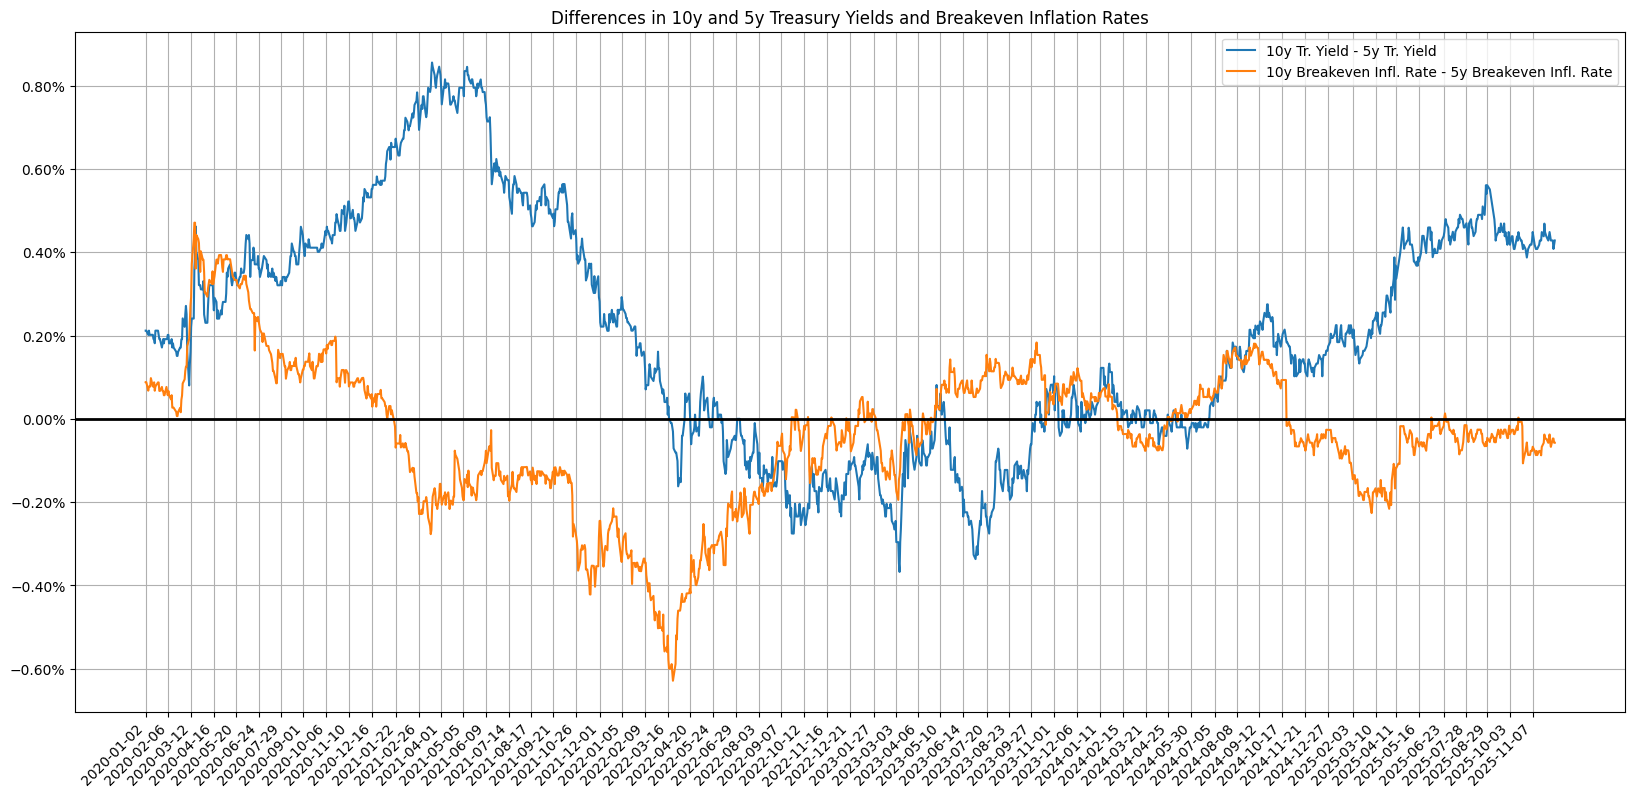

In [7]:
ax = data.iloc[:,:2].plot(figsize=(20,10), grid=True,
                          title='Differences in 10y and 5y Treasury Yields and Breakeven Inflation Rates',
                          xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [8]:
date_of_inversion = data.iloc[:,0][data.iloc[:,0] < 0].index[0]
date_of_inversion_last = data.iloc[:,0][data.iloc[:,0] < 0].index[-1]
date_of_inversion_peak = data.iloc[:,0].idxmin()
print(f'The inversion of 10-Year - 5-Year yield curves happened on {date_of_inversion:%Y-%m-%d}')
print(f'The peak of inversion was {data.iloc[:,0].min()*1e4:.0f}bps and took place on {date_of_inversion_peak:%Y-%m-%d}')
date_of_inversion_finish = data.iloc[:,0][(data.iloc[:,0] > 0) & (data.index > date_of_inversion_last)]
if len(date_of_inversion_finish) > 0:
    print(f'The inversion ended on {date_of_inversion_finish.index[0]:%Y-%m-%d}')
print(f'The 10-Year - 5-Year yield spread amounts to {data.iloc[-1,0]*1e4:+.0f}bps as of {data.index[-1]:%Y-%m-%d}')

The inversion of 10-Year - 5-Year yield curves happened on 2022-03-21
The peak of inversion was -37bps and took place on 2023-03-08
The inversion ended on 2024-06-28
The 10-Year - 5-Year yield spread amounts to +43bps as of 2025-12-11


What can we conclude? The yield curve inversion (between 10-year and 5-year treasury yields) that started in March-April 2022 was mostly brought about by growing expectations that average 10-year inflation will be less than the average inflation in the coming 5 years. As of September 2024, the 10- and 5-year breakeven inflation rates reverted to their usual state with 10-year breakeven inflation higher than 5-year one, as a result the reversion of the yield curve is went away too.

From October 2024 onwards, however, the 10-year breakeven inflation rate again started to trend lower than the 5-year breakeven inflation rate. The only reason the yield curve inversion didn't take place again is because of the growing term premium on 10-year treasury yield which is higher than the difference between 5- and 10-year breakeven inflation. See the _Term premium on 10-Year Treasury Securities_ section of this notebook for more details.

Let's now visualize the: 1) 10-Year Treasury Yield - 2-Year Treasury Yield, and 2) 10-Year Treasury Yield - 3-Month Treasury Yield spreads:

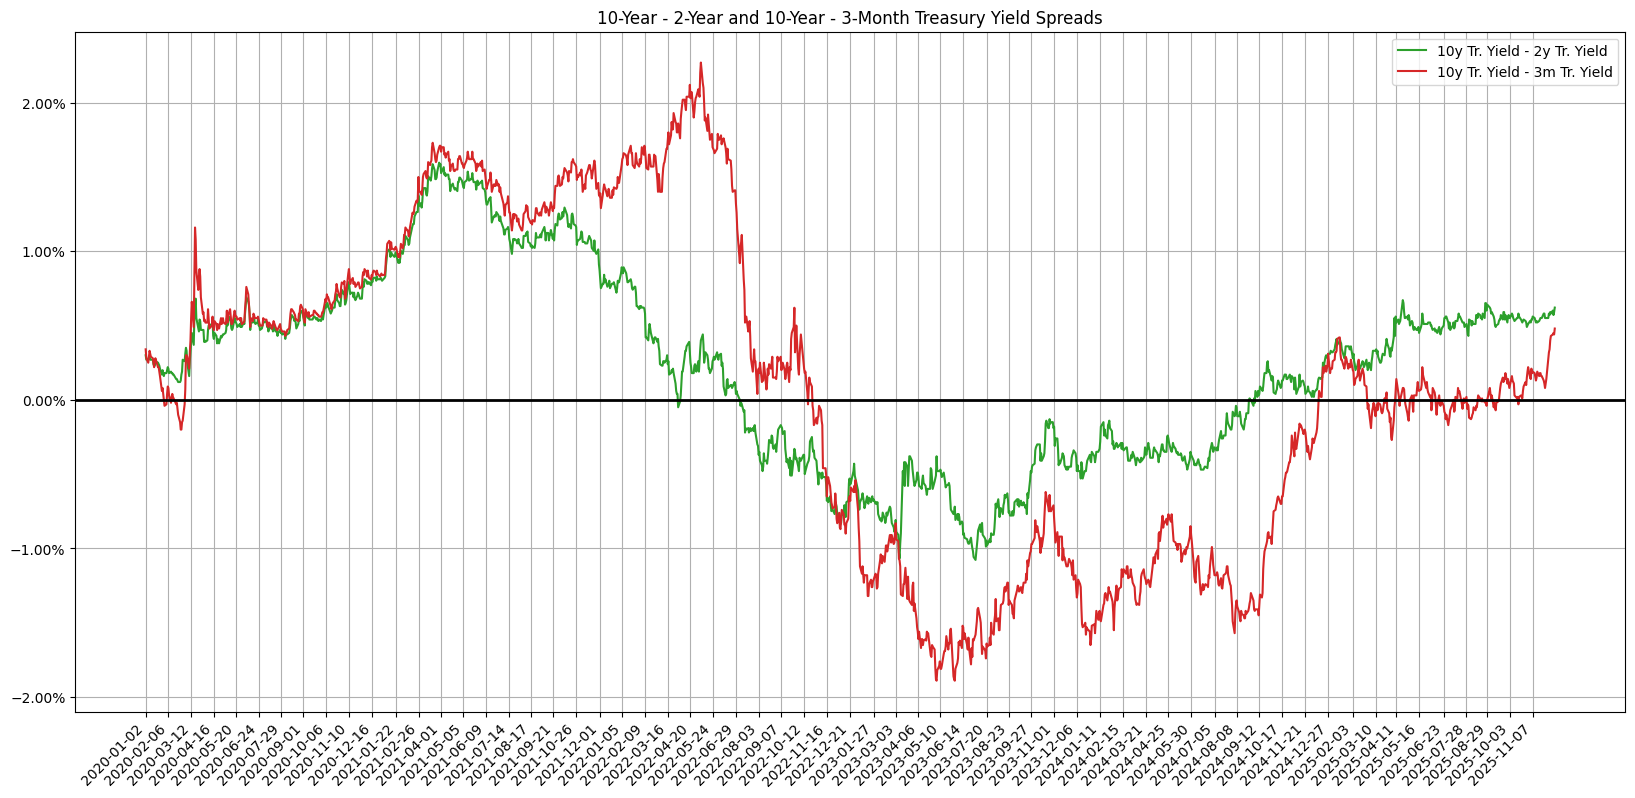

In [9]:
ax = data.iloc[:,2:].plot(figsize=(20,10), grid=True,
               title='10-Year - 2-Year and 10-Year - 3-Month Treasury Yield Spreads', color=['#2ca02c', '#d62728'],
               xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [10]:
date_of_inversion = data.iloc[:,2][data.iloc[:,2] < 0].index[0]
date_of_inversion_last = data.iloc[:,2][data.iloc[:,2] < 0].index[-1]
date_of_inversion_peak = data.iloc[:,2].idxmin()
print(f'The inversion of 10-Year - 2-Year yield curves happened on {date_of_inversion:%Y-%m-%d}')
print(f'The peak of inversion was {data.iloc[:,2].min()*1e4:.0f}bps and took place on {date_of_inversion_peak:%Y-%m-%d}')
print(f'The inversion amounts to {data.iloc[-1,2]*1e4:+.0f}bps as of {data.index[-1]:%Y-%m-%d}')
date_of_inversion_finish = data.iloc[:,2][(data.iloc[:,2] > 0) & (data.index > date_of_inversion_last)]
if len(date_of_inversion_finish) > 0:
    print(f'The inversion ended on {date_of_inversion_finish.index[0]:%Y-%m-%d}')
print(f'The 10-Year - 2-Year yield spread amounts to {data.iloc[-1,2]*1e4:+.0f}bps as of {data.index[-1]:%Y-%m-%d}')

The inversion of 10-Year - 2-Year yield curves happened on 2022-04-01
The peak of inversion was -108bps and took place on 2023-07-03
The inversion amounts to +62bps as of 2025-12-11
The inversion ended on 2024-09-06
The 10-Year - 2-Year yield spread amounts to +62bps as of 2025-12-11


## Analyzing 10-Year - 2-Year curve inversion with the help of 10-Year and 2-Year Expected inflation data
Given that [The Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org) doesn't publish breakeven inflation data for 2-Year maturity, we can use 2-Year expected inflation as a substitute. The Federal Reserve Bank of Cleveland calculates it based on inflation swap data, Treasury Yields, current CPI, Blue Chip forecast of CPI. Analyzing the differences between 5-Year Breakeven inflation rate and 5-Year exected inflation shows that the mean difference is 32bps and standard diviation is 37bps.

Unfortunately I need to switch from daily to monthly freqencies given that this is the finest granularity at which expected inflation data is provided.

I use the following dataseries from FRED to accomplish the task:
* `EXPINF2YR` &mdash; 2-Year Expected Inflation (monthly frequency)
* `EXPINF5YR` &mdash; 5-Year Expected Inflation (monthly frequency)
* `EXPINF10YR` &mdash; 10-Year Expected Inflation (monthly frequency)
* `T5YIEM` &mdash; 5-Year Breakeven Inflation Rate (monthly frequency)
* `T10YIEM` — 10-Year Breakeven Inflation Rate (monthly frequency)
* `T10Y2YM` - &mdash;  10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (monthly frequency)

In [11]:
data2 = web.get_data_fred(['EXPINF5YR', 'T5YIEM', 'EXPINF2YR', 'T10YIEM', 'EXPINF10YR', 'T10Y2YM'],
                          '2000-01-01', report_end) / 100.
data2.dropna(inplace=True)

In [12]:
# Only T10Y2YM is based on a yield with a semiannual compounding frequency
columns_with_semiannual_comp = ['T10Y2YM']

# Converting all CMT Yields to APY (i.e. all but breakeven inflation rates)
data2.loc[:, columns_with_semiannual_comp] = (data2.loc[:, columns_with_semiannual_comp]/2 + 1)**2 - 1

Let's first compare 5-Year breakeven inflation data with 5-Year expected inflation data to see if they are close enough to use the latter as a substitute for the former for shorter maturities (e.g. the 2-Year maturity I am interested in).

In [13]:
abs_diff = (data2.iloc[:,0]-data2.iloc[:,1]).abs()
abs_diff.describe()

count    274.000000
mean       0.003024
std        0.003614
min        0.000018
25%        0.000797
50%        0.001821
75%        0.003971
max        0.031894
dtype: float64

They look close enough: the mean difference is 32bps and standard diviation is 37bps. Let's now look at the standard error:

In [14]:
abs_diff.sem()

np.float64(0.00021831196887045623)

It is small enough at 2bps. Therefore I will adopt the hypothesis that epxected inflation data can be used as a substiture for breakeven inflation.

In [15]:
# Getting rid of no longer needed columns, and calculating the difference between 10-Year and 2-Year
# expected inflation
data2['10y Breakeven Infl. Rate - 2y Expected Infl. Rate'] = data2.iloc[:,3] - data2.iloc[:,2]
data2['10y Expected Infl. Rate - 2y Expected Infl. Rate'] = data2.iloc[:,4] - data2.iloc[:,2]
data2 = data2.iloc[:,5:]
data2.rename(columns={'T10Y2YM': '10y Tr. Yield - 2y Tr. Yield'}, inplace=True)

### Visualizing the spreads

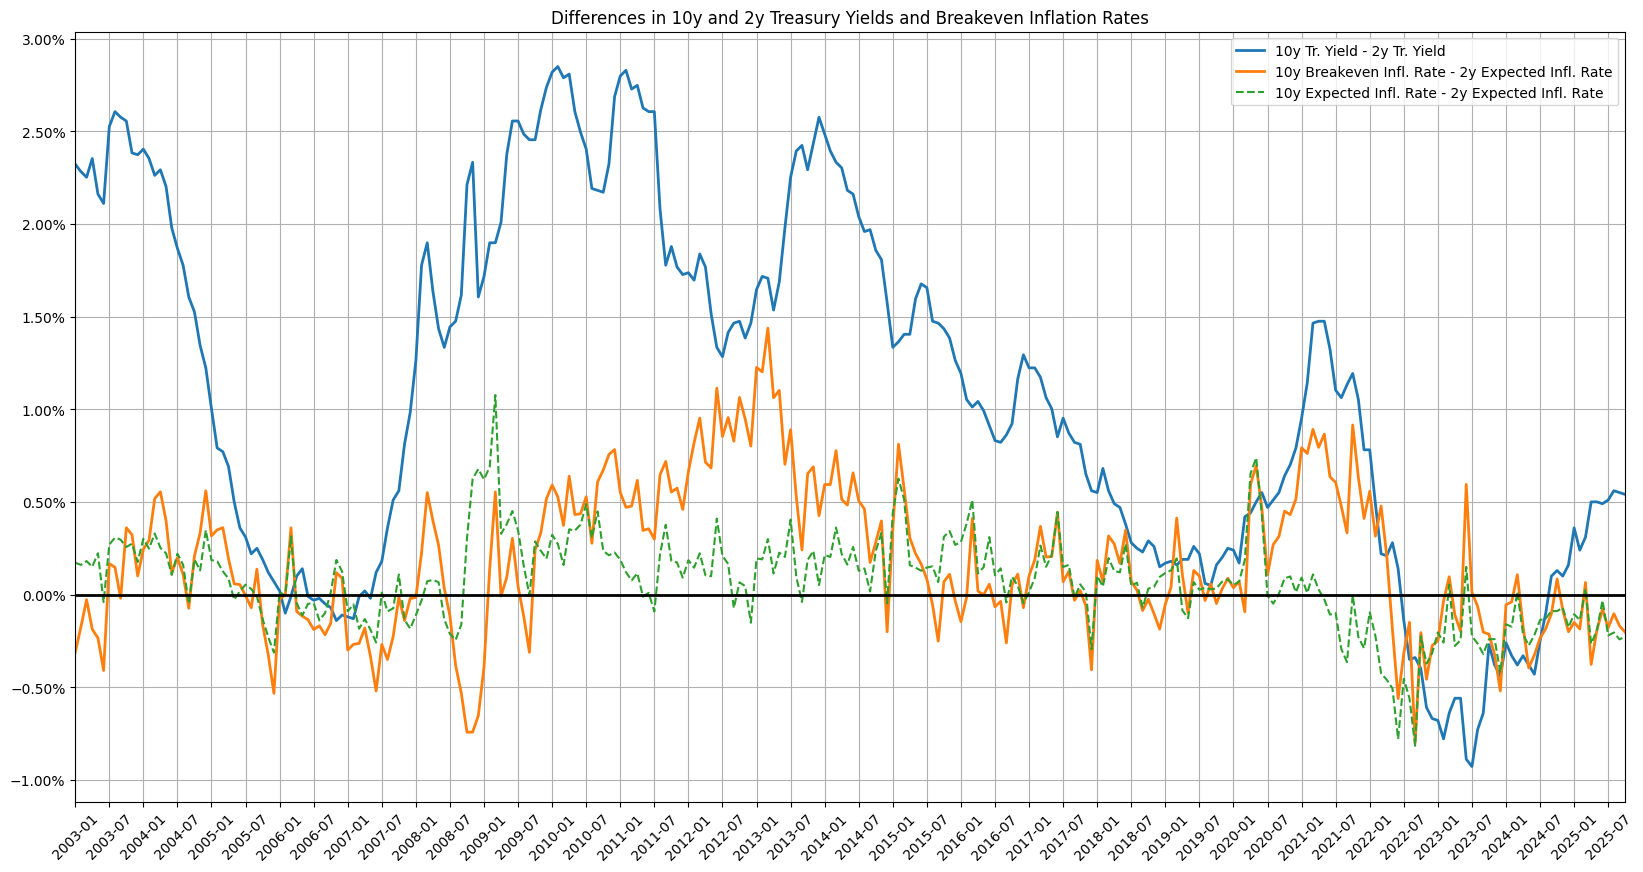

In [16]:
ax = data2.iloc[:, :2].plot(figsize=(20,10), grid=True, linewidth=2,
                title='Differences in 10y and 2y Treasury Yields and Breakeven Inflation Rates',
                xticks=data2.index[::6], xlabel='', rot=45)
ax = data2.iloc[:, 2:].plot(ax=ax, grid=True, xticks=data2.index[::6], xlabel='', rot=45, linestyle='--')
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data2.index[::6])))

What can we conclude? We see a similar trend for the spread between 10-Year and 5-Year yields although less pronounced &mdash; the inversion was to some extent caused by 10-Year inflation expectations being less that 2-Year ones. Now (as of November 2024) the 10- and 2-year inflation expectations are becoming increasingly similar, which causes the 10- and 2-year Treasury yield inversion to disappear.

## Term premium on 10-Year Treasury Securities
One important metric that can be deduced from interest rate spreads is _the term premium_ (also known as _the real term premium_). I mentioned it in the beginning of this notebook; see Equation 1. To recap, the `real term premium` is the extra compensation that bond investors demand for bearing real interest rate risks, i.e., the risk that short-term rates will turn out to be different from those expected. Figuring out the term premium allows for a better understanding of the causes behind changes in treasury yields.

Let's derive it for 10-Year treasury yield. The following equations will come in handy:

`real yield = expected average future real short rate + real term premium (2)`

`TIPS yield = real yield + TIPS liquidity premium (3)`

Ignoring the TIPS liquidity premium, an approximation of the term premium for a 10-Year Treasury Security is:
`real term premium = 10-Year TIPS yield - 1-Year TIPS yield`.
Unfortunately, [the Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org) does not publish TIPS yields for 1-Year maturities. Therefore, I will use 1-Year expected inflation from the Federal Reserve Bank of Cleveland as a substitute.

I use the following dataseries from FRED to accomplish the task:
* `WFII10` &mdash;  Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Inflation-Indexed (weekly frequency designating average for the week, yield expressed with semiannual compounding frequency)
* `DGS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, (daily frequency, yield expressed with semiannual compounding frequency)
* `EXPINF1YR` &mdash; 1-Year Expected Inflation (monthly frequency)

I convert all frequencies to weekly by downsampling `DGS1` and upsampling `EXPINF1YR`.

In [17]:
report_start = date(2010, 1, 1)
data4_fii10 = web.get_data_fred('WFII10', report_start, report_end).resample('W-FRI').last()
data4_gs1 = web.get_data_fred('DGS1', report_start, report_end).resample('W-FRI').mean()
data4_inf1yr = web.get_data_fred('EXPINF1YR', report_start, report_end).resample('W-FRI').last().ffill()
data4 = pd.concat([data4_fii10, data4_gs1, data4_inf1yr], axis=1) / 100.
data4.dropna(subset=['WFII10', 'DGS1'], inplace=True)
data4.ffill(inplace=True)

# Converting all CMT Yields to APY (i.e. all but expected inflation rates)
data4.update((data4.iloc[:, :2]/2 + 1)**2 - 1)

In [18]:
data4['WFII1'] = data4.DGS1 - data4.EXPINF1YR
data4['Term Premium'] = data4.WFII10 - data4.WFII1
data4.drop(['DGS1', 'EXPINF1YR'], axis=1, inplace=True)

In [19]:
data4

,WFII10,WFII1,Term Premium
DATE,,,
2010-01-08,0.014553,-0.012893,0.027446
2010-01-15,0.014049,-0.013495,0.027544
2010-01-22,0.013244,-0.013830,0.027074
2010-01-29,0.013344,-0.013835,0.027179
2010-02-05,0.012942,-0.014033,0.026975
...,...,...,...
2025-11-07,0.018384,0.009608,0.008775
2025-11-14,0.018485,0.009613,0.008871
2025-11-21,0.018586,0.009506,0.009079


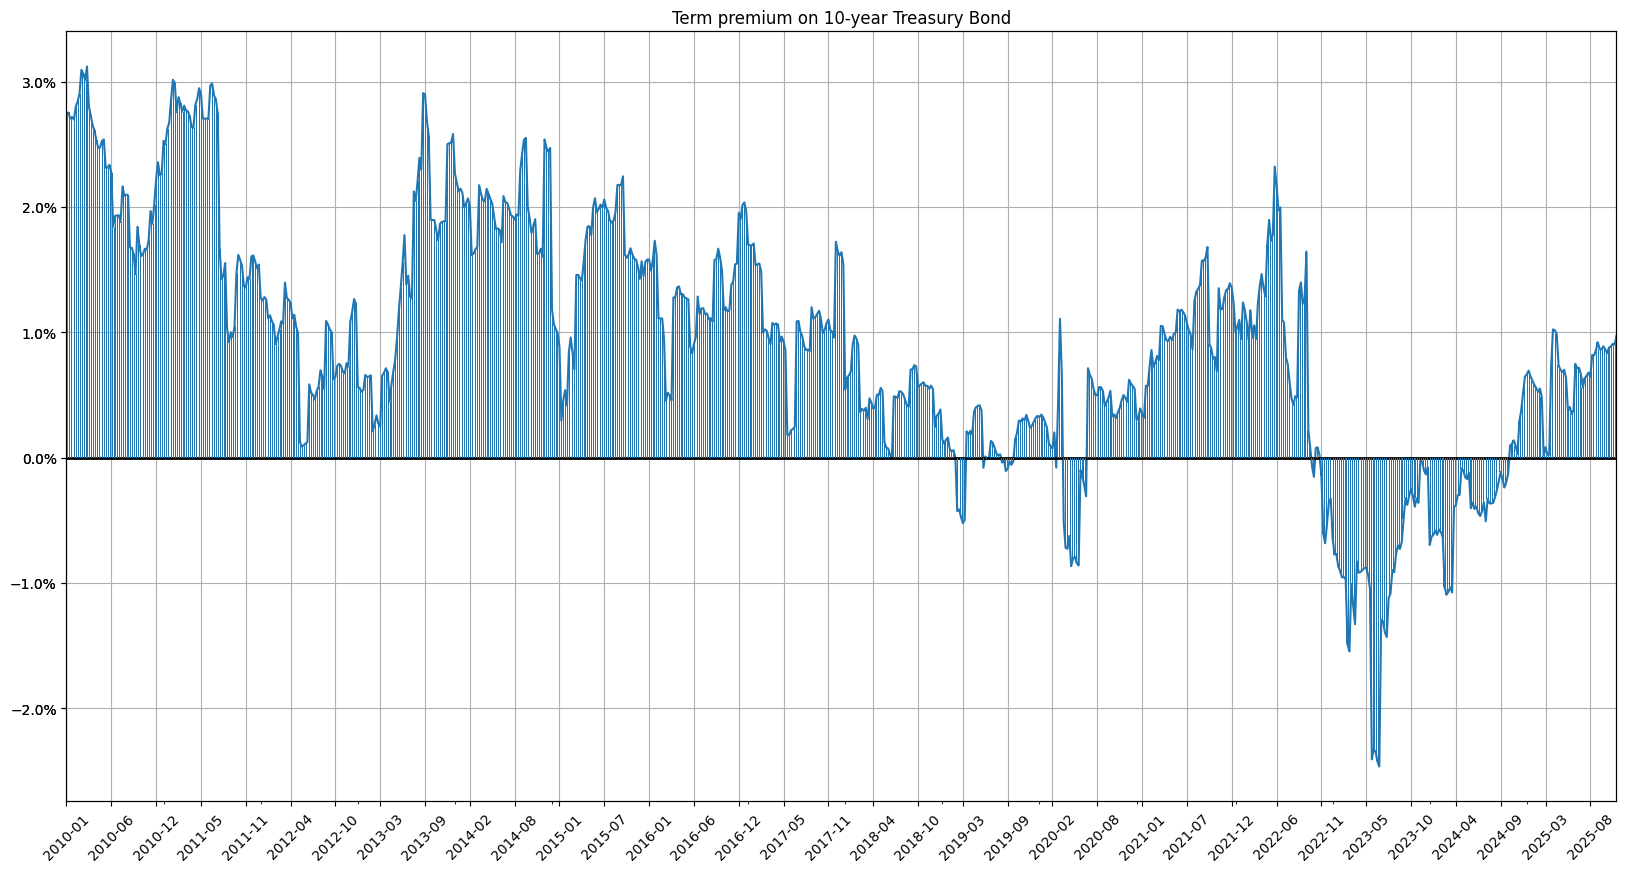

In [20]:
ax = data4.iloc[:,2].plot(figsize=(20,10), grid=True,
                          title='Term premium on 10-year Treasury Bond',
                          xticks=data4.index[::24], xlabel='', rot=45)
ax2 = ax.twiny()
data4.iloc[:,2].plot.bar(ax=ax2, xlabel='', legend=False)
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data4.index[::24])))

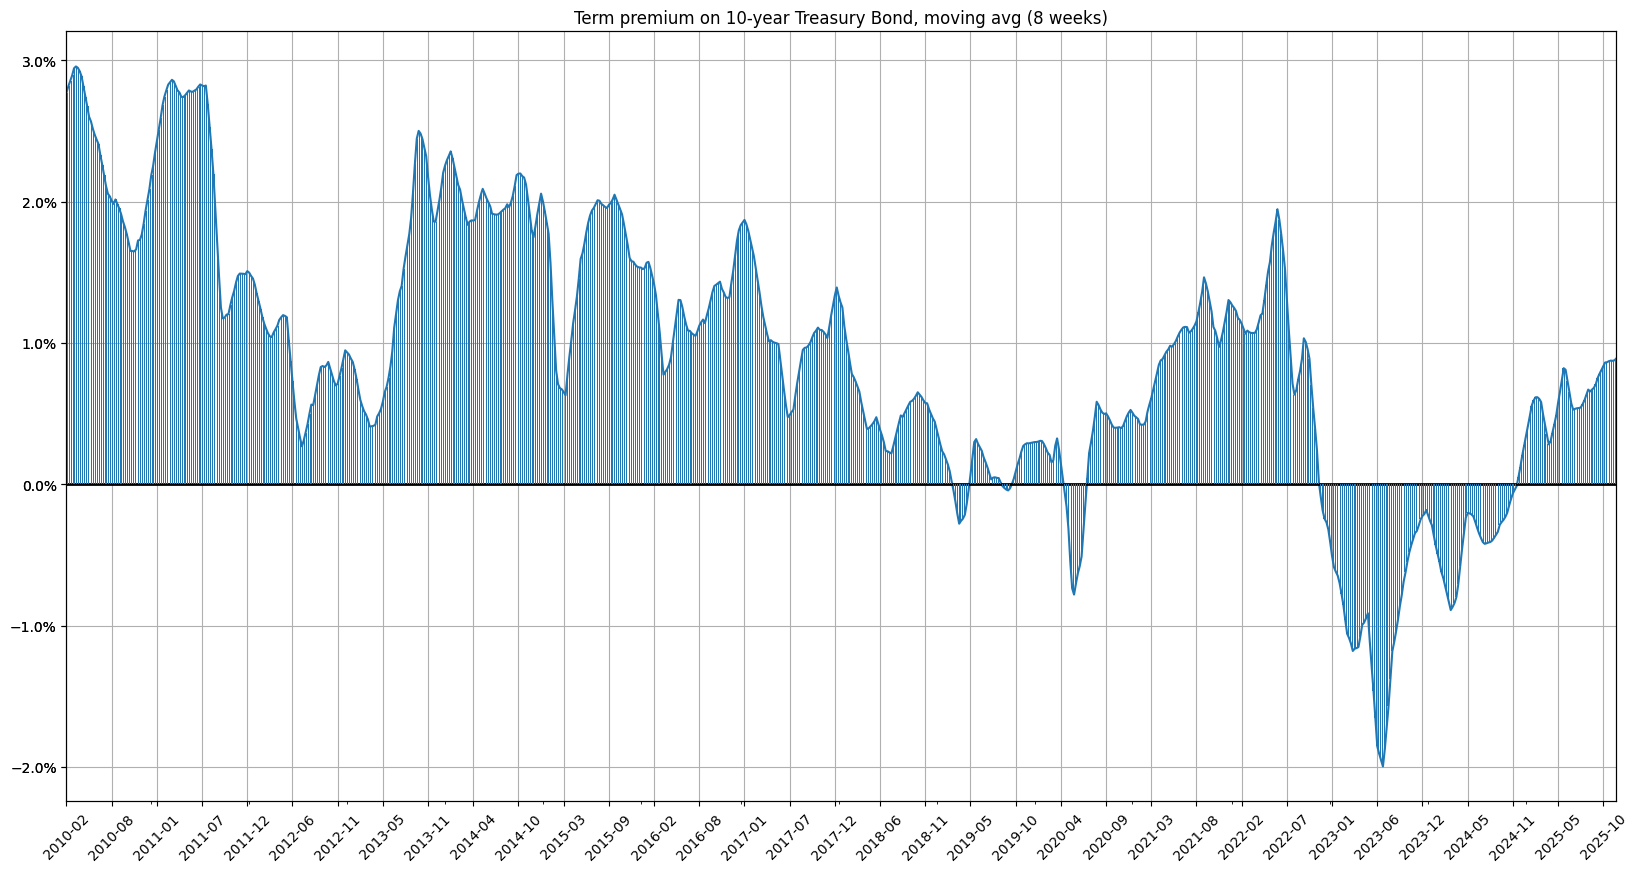

In [21]:
term_premium_ma = data4.iloc[:,2].rolling(8).mean().dropna()
ax = term_premium_ma.plot(figsize=(20,10), grid=True,
                          title='Term premium on 10-year Treasury Bond, moving avg (8 weeks)',
                          xticks=term_premium_ma.index[::24], xlabel='', rot=45)
ax2 = ax.twiny()
term_premium_ma.plot.bar(ax=ax2, xlabel='', legend=False)
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, term_premium_ma.index[::24])))